In [1]:
import warnings

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm

from experimentation.plotting import plot_pvalues

warnings.filterwarnings("ignore")



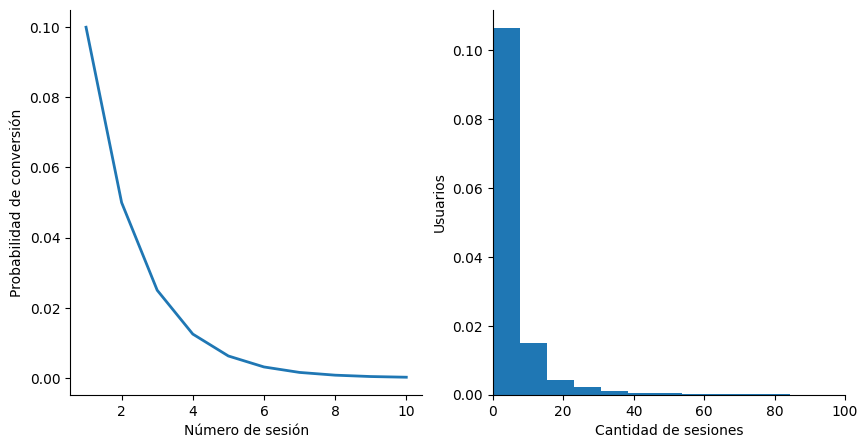

In [2]:
def sesiones(sample_size):
    return np.random.lognormal(mean=1.0, sigma=1.2, size=sample_size).astype(int)


def p_conversion(sesion):
    return 0.1 * np.exp(-np.log(2) * (sesion - 1))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(np.arange(1, 11), p_conversion(np.arange(1, 11)), linewidth=2)
ax1.set_xlabel("Número de sesión")
ax1.set_ylabel("Probabilidad de conversión")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.hist(sesiones(100_000), density=True, bins=100)
ax2.set_xlabel("Cantidad de sesiones")
ax2.set_xlim(0, 100)
ax2.set_ylabel("Usuarios")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

## Generación del dataset

El dataset se genera para `n_usuarios`, donde las `sesiones` son un generador aleatorio de número de sesiones (por defecto, la lognormal graficada arriba) y la `p_conversion` es una función de la probabilidad de conversión para cada sesión.

`n_sesiones` es un vector con la cantidad de sesiones para cada usuario. Para cada usuario se guardan `n_sesiones` filas, donde cada una de ellas tiene una probabilidad de convertir de acuerdo a `p_conversion(índice_de_sesión)`. Si el usuario convirtió, decimos que es poco probable que pueda volver a convertir, por lo que dejamos el resto de las sesiones en conversión 0. Así cada usuario, como mucho, puede convertir una sola vez.

In [3]:
def crear_dataset(n_usuarios, sesiones=sesiones, p_conversion=p_conversion):
    n_sesiones = sesiones(n_usuarios)
    user_ids = np.array([], dtype=int)
    conversion = np.array([], dtype=int)

    for i, n_sesiones_este_usuario in enumerate(n_sesiones, start=1):
        # Genera un vector de i repetido n_sesiones_este_usuario veces. Si
        # i es 5 (el id del usuario) y n_sesiones es 2, da (5, 5)
        repeated_ids = np.full(n_sesiones_este_usuario, i)
        user_ids = np.concatenate((user_ids, repeated_ids))
        this_user_conversions = np.zeros(n_sesiones_este_usuario, dtype=np.int32)
        for j in range(n_sesiones_este_usuario):
            # Para cada sesión me fijo si el usuario convierte y, si convirtió,
            # entonces no puede volver a convertir (por eso el break)
            if np.random.random() < p_conversion(j):
                this_user_conversions[j] = 1
                break
        conversion = np.concatenate((conversion, this_user_conversions))

    dataset = pd.DataFrame(columns=["user_id", "conversion"])
    dataset["user_id"] = user_ids
    dataset["conversion"] = conversion
    return dataset

Así se ve el dataset, por ejemplo, para sólo 5 usuarios

In [4]:
dataset_chico = crear_dataset(5)
dataset_chico

,user_id,conversion
0,1,0
1,1,0
2,1,0
3,1,0
4,2,0
5,2,0
6,3,1
7,3,0
8,3,0
9,4,0


Ahora vamos a calcular los p-values con un t-test (para esta cantidad, un t-test y un z-test dan lo mismo) para la media de conversiones por sesión:

In [5]:
usuarios = 1_000

# Creo la cantidad de usuarios para cada split, 50% para cada lado
usuarios_a = sp.stats.binom.rvs(usuarios, 0.5)
usuarios_b = usuarios - usuarios_a

# Creo el dataset para cada rama
rama_a = crear_dataset(usuarios_a)
rama_b = crear_dataset(usuarios_b)
sp.stats.ttest_ind(
    rama_a["conversion"], rama_b["conversion"], alternative="greater"
).pvalue

np.float64(0.996919840282849)

Si calculamos los p-values en 1000 experimentos distintos, esperamos que estén uniformemente distribuidos (porque estamos en las condiciones de la hipótesis nula).

In [6]:
usuarios = 1_000
n_experiments = 1_000
pvalues_por_sesion = np.zeros(n_experiments)

for i in tqdm(range(n_experiments)):
    usuarios_a = sp.stats.binom.rvs(usuarios, 0.5)
    usuarios_b = usuarios - usuarios_a
    rama_a = crear_dataset(usuarios_a)
    rama_b = crear_dataset(usuarios_b)
    conversiones_a = rama_a["conversion"]
    conversiones_b = rama_b["conversion"]
    pvalues_por_sesion[i] = sp.stats.ttest_ind(
        conversiones_a, conversiones_b, alternative="greater"
    ).pvalue

100%|██████████| 1000/1000 [00:21<00:00, 46.94it/s]


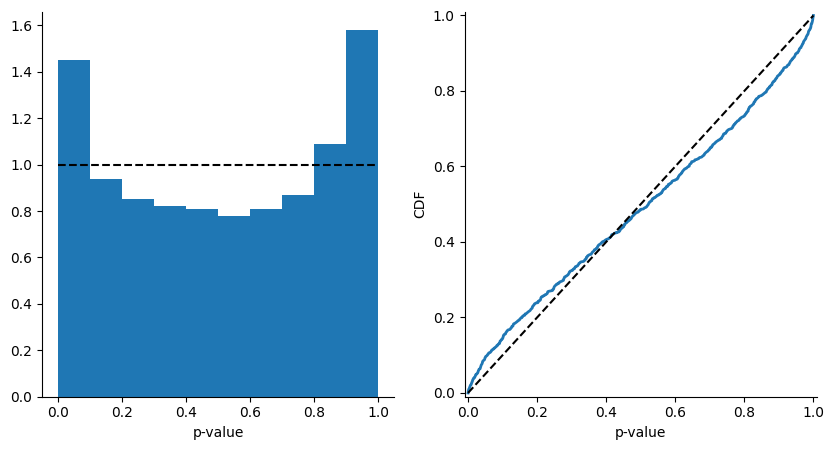

In [7]:
plot_pvalues(pvalues_por_sesion);

Sin embargo, vemos que no. Esto se debe a que las sesiones no son independientes entre sí.

Veamos el caso ahora en el que vemos la media de conversiones _por usuario_. Al agrupar por usuario y sumar las conversiones, tenemos cuántas veces convirtió cada usuario. Como un usuario como mucho puede convertir 1 vez (por nuestra construcción), esto es un vector de 0 y 1. Podríamos permitir que los usuarios conviertan más de una vez y el resultado seguiría siendo el mismo

In [8]:
dataset_chico.groupby("user_id").sum("conversion")

,conversion
user_id,
1,0
2,0
3,1
4,0
5,0


La distribución de los p-values en este caso es uniforme

In [9]:
pvalues_usuario = np.zeros(n_experiments)

for i in tqdm(range(n_experiments)):
    usuarios_a = sp.stats.binom.rvs(usuarios, 0.5)
    usuarios_b = usuarios - usuarios_a
    rama_a = crear_dataset(usuarios_a)
    rama_b = crear_dataset(usuarios_b)
    conversiones_a = rama_a.groupby("user_id").sum("conversion")
    conversiones_b = rama_b.groupby("user_id").sum("conversion")
    pvalues_usuario[i] = sp.stats.ttest_ind(
        conversiones_a, conversiones_b, alternative="greater"
    ).pvalue

100%|██████████| 1000/1000 [00:21<00:00, 46.66it/s]


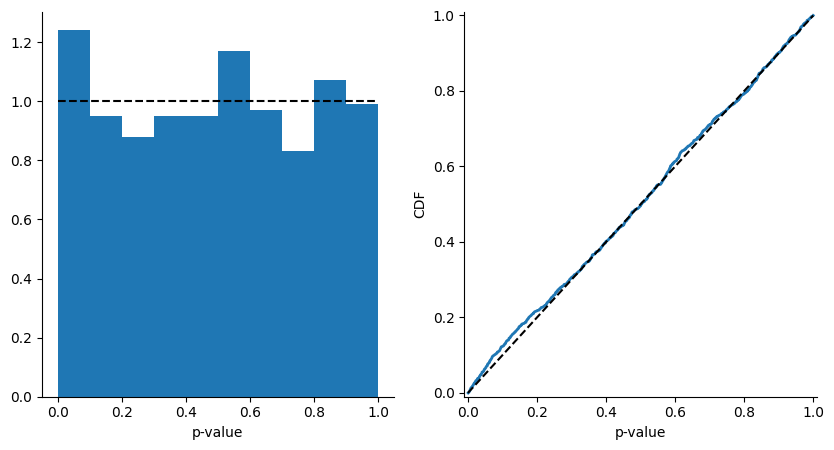

In [10]:
plot_pvalues(pvalues_usuario);

Pero qué pasa si queremos efectivamente hacer un test sobre el promedio de conversiones por sesión y no por usuario? En ese caso tenemos que corregir la varianza a través del delta method[1]:

[1]: https://alexdeng.github.io/public/files/wsdm2017-rup.pdf

In [11]:
def delta_method(numerador_a, denominador_a, numerador_b, denominador_b):
    def mean_and_sem(numerador, denominador):
        mean = np.mean(numerador) / np.mean(denominador)
        var = np.var(numerador) / np.mean(denominador) ** 2
        var += np.mean(numerador) ** 2 / np.mean(denominador) ** 4 * np.var(denominador)
        var -= (
            2
            * np.mean(numerador)
            / np.mean(denominador) ** 3
            * np.cov(denominador, numerador)[0, 1]
        )
        sem = np.sqrt(var / len(numerador))
        return mean, sem

    mean_a, sem_a = mean_and_sem(numerador_a, denominador_a)
    mean_b, sem_b = mean_and_sem(numerador_b, denominador_b)
    sem_diff = np.sqrt(sem_a**2 + sem_b**2)
    mean_diff = mean_b - mean_a
    return sp.stats.norm.cdf(mean_diff / sem_diff)

Y estos sí están, efectivamente, uniformemente distribuidos

In [12]:
pvalues_delta = np.zeros(n_experiments)

for i in tqdm(range(n_experiments)):
    usuarios_a = sp.stats.binom.rvs(usuarios, 0.5)
    usuarios_b = usuarios - usuarios_a
    rama_a = crear_dataset(usuarios_a)
    rama_b = crear_dataset(usuarios_b)
    conversiones_a = rama_a.groupby("user_id").sum("conversion").values.flatten()
    conversiones_b = rama_b.groupby("user_id").sum("conversion").values.flatten()
    sesiones_a = rama_a.groupby("user_id").count().values.flatten()
    sesiones_b = rama_b.groupby("user_id").count().values.flatten()
    pvalues_delta[i] = delta_method(
        conversiones_a, sesiones_a, conversiones_b, sesiones_b
    )

100%|██████████| 1000/1000 [00:24<00:00, 41.23it/s]


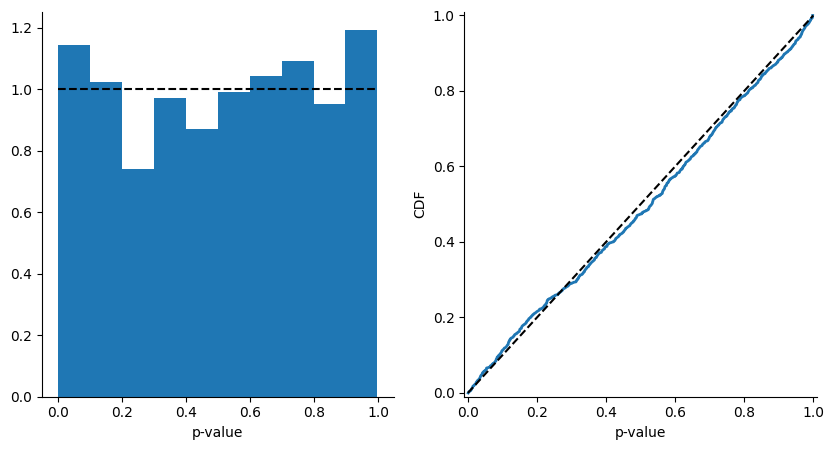

In [13]:
plot_pvalues(pvalues_delta);